# Import libraries & data

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [28]:
customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')

# Lab 1 - Numerical data cleaning

In [ ]:
# No NaNs values in the dataset

display(customer_df.info()) # or this code for nulls: customer_df.isnull().sum()/len(customer_df). But we can see already w/ info 
display(customer_df.shape)
customer_df.head()

In [ ]:
customer_df.describe().T

In [29]:
# For loop to replace the column headers with lowercase snake format

n_cols = []
for i in range(len(customer_df.columns)):
    n_cols.append(customer_df.columns[i].lower().replace(' ','_'))

customer_df.columns = n_cols


In [30]:
# The above code did not fix employmentstatus so I've done this. I'm sure there is a way to do it in the loop with regex...

customer_df = customer_df.rename(columns = {'employmentstatus':'employment_status'})

In [31]:
# Change effective to date into a datetime format column

customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'])

In [32]:
# To understand the data better (and clean as appropriate), we will start by separating numerical from the categorical

numerical = customer_df.select_dtypes(include=np.number)
categorical = customer_df.select_dtypes(include=object)

In [ ]:
numerical.columns

In [ ]:
numerical.shape[0] # This is the number of rows 

In [ ]:
# In the numerical data, we need to separate the continuous from discrete variables

discrete_lst = []
continuous_lst = []

for col in numerical.columns:
    if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
        discrete_lst.append(col)
    else:
        continuous_lst.append(col)
display(discrete_lst)
display(continuous_lst)

In [34]:
# Function to pass the discrete / continuous split to the numerical dataset

def discrete_continuous(df):
    discrete_lst = []
    continuous_lst = []
    for col in numerical.columns:
        if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
            discrete_lst.append(col)
        else:
            continuous_lst.append(col)
    return (discrete_lst, continuous_lst)

In [35]:
# Apply the function

discrete_lst, continuous_lst = discrete_continuous(numerical)

In [ ]:
# Plot a correlation matrix
# We see that monthly_premium_auto is moderately correlated with both customer_lifetime_value (0.4) and total_claim_amount (0.63)
# Total_claim_amount has a weak negative correlation with income (-0.36)
# Nothing here would lead us to cut out a column in the numerical data

correlations = numerical.corr()

fig, ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(correlations, cmap='mako_r', annot=True)
plt.show()

In [ ]:
# Plot the numerical variables to see their skew / distributions
# Note: These four variables could be converted to categoricals but I don't think it's necessary here

for column in numerical[discrete_lst]:
    sns.displot(numerical[column], kde=True)
    plt.show()

In [ ]:
# Plot the categorical variables

for column in numerical[continuous_lst]:
    sns.histplot(numerical[column])
    plt.show()

In [ ]:
# Checking for outliers in the continuous variables

for column in numerical[continuous_lst]:
    sns.boxplot(numerical[column])
    plt.show()

In [ ]:
# Dealing with outliers -- using the IQR and a function to pass it to all variables
# We could also try a log transform (perhaps instead?)

def detect_outlier(column):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(column), [25, 75])
 
    # compute IQR
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in column if x <= lower_bound or x >= upper_bound]
 
    return outliers

In [ ]:
clv_outliers = detect_outlier(numerical['customer_lifetime_value'])
tca_outliers = detect_outlier(numerical['total_claim_amount'])
mpa_outliers = detect_outlier(numerical['monthly_premium_auto'])

display(len(clv_outliers), len(tca_outliers), len(mpa_outliers))

customer_df.shape

# Not sure if we want to strike these outliers as it may cause us to lose a lot of data.

# Perhaps a log transform instead?


# Lab 2 - categorical data cleaning

In [ ]:
# Explore the categorical data for anomalies. We already know from above that there are no NaNs to deal with... 

categorical.head()

In [ ]:
categorical['state'].unique()

In [ ]:
def cntplot_cat(df):
    for column in categorical.columns:
        sns.countplot(x=categorical[column])
        plt.show()
    return None
   
cntplot_cat(categorical)

sns.set_theme(style="whitegrid")

In [36]:
# Drop the customer variable because it if not helpful for our analysis

categorical = categorical.drop(['customer'], axis = 1)

In [ ]:
categorical_columns = [col for col in categorical if (len(categorical[col].unique()) < (categorical.shape[0] * 0.01))]

In [ ]:
# Fix education -- try to filter it into four categories instead (Note: not sure how college and bachelor differ)

categorical.loc[categorical["education"].isin(['Master','Doctor'])] = "Graduate"

collapse = categorical["education"].value_counts().index[:3]
categorical["education"] = np.where(categorical["education"].isin(collapse), categorical["education"], 'Graduate')
categorical["education"].value_counts(dropna=False)

In [ ]:
# Run the same operation for vehicle_type

collapse2 = categorical["vehicle_class"].value_counts().index[:3]
categorical["vehicle_class"] = np.where(categorical["vehicle_class"].isin(collapse2), categorical["vehicle_class"], 'Luxury')
categorical["vehicle_class"].value_counts(dropna=False)

In [39]:
# Encode 'response' to be 0 or 1 so we can fix the data imbalance later...

def yes_no(x):
    if x=='Yes':
        return 1
    else:
        return 0

categorical['response'] = list(map(yes_no,categorical['response']))

In [ ]:
display(categorical["policy"].value_counts(dropna=False))
categorical["policy_type"].value_counts(dropna=False)

In [40]:
# Given the similarity of policy and policy_type, we can remove policy altogether (and maybe drop Special Auto as well)

categorical = categorical.drop(['policy'], axis = 1)

In [ ]:
# This is out final output for categorical variables:
 
categorical

# Feature extraction

In [41]:
categorical # I've already cleaned the categorical data to my liking above. See results:

,state,response,coverage,education,employment_status,gender,location_code,marital_status,policy_type,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,0,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,0,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,0,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Offer1,Agent,Two-Door Car,Medsize
3,California,0,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Offer1,Call Center,SUV,Medsize
4,Washington,0,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,California,0,Basic,Bachelor,Employed,M,Urban,Married,Personal Auto,Offer2,Web,Four-Door Car,Medsize
9130,California,1,Extended,College,Employed,F,Suburban,Divorced,Corporate Auto,Offer1,Branch,Four-Door Car,Medsize
9131,California,0,Extended,Bachelor,Unemployed,M,Suburban,Single,Corporate Auto,Offer1,Branch,Four-Door Car,Medsize
9132,California,0,Extended,College,Employed,M,Suburban,Married,Personal Auto,Offer3,Branch,Four-Door Car,Large


In [ ]:
def cntplot_cat(df):
    for column in categorical.columns:
        sns.countplot(x=categorical[column])
        plt.show()
    return None
   
cntplot_cat(categorical)

sns.set_theme(style="whitegrid")

In [48]:
customer_df['effective_to_date']

0      2011-02-24
1      2011-01-31
2      2011-02-19
3      2011-01-20
4      2011-02-03
          ...    
9129   2011-02-10
9130   2011-02-12
9131   2011-02-06
9132   2011-02-03
9133   2011-02-14
Name: effective_to_date, Length: 9134, dtype: datetime64[ns]

In [52]:
customer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_lifetime_value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
monthly_premium_auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
months_since_last_claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
months_since_policy_inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
number_of_open_complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
number_of_policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
total_claim_amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678


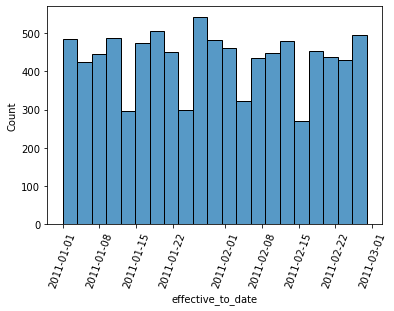

In [56]:
sns.histplot(customer_df['effective_to_date'])
plt.xticks(rotation=70)
plt.show()

# With the histogram plot we see the frequency of policy expirations by date in the first quarter of 2011
# There may be a bi-weekly 'seasonality' so the renewal of insurance may come around recieving the paycheck?

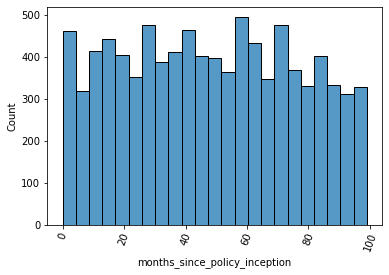

In [67]:
sns.histplot(customer_df['months_since_policy_inception'])
plt.xticks(rotation=70)
plt.show()

# Doesn't look like there are any links between 'effective_to_date' and months since policy inception
# if we map these plots on top of each other (they have different scales anyway)